In [49]:
#A code to fit continuum, pseudo-continuum, and/or baselines to image cubes from the JWST nirspec ifu
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from spectral_cube import SpectralCube

Options forbaseline fitting

Asymmetric least squares smoother: from spectrapepper: https://github.com/spectrapepper/spectrapepper/blob/main/spectrapepper/functions.py

see function alsbaseline

last parameters that worked: smooth_list = [10000, 0.1, 0.1, 1, 10, 10, 0.1, 1], p_list = [0.05, 0.01, 0.05, 0.005, 0.0005, 0.01, 0.0001]


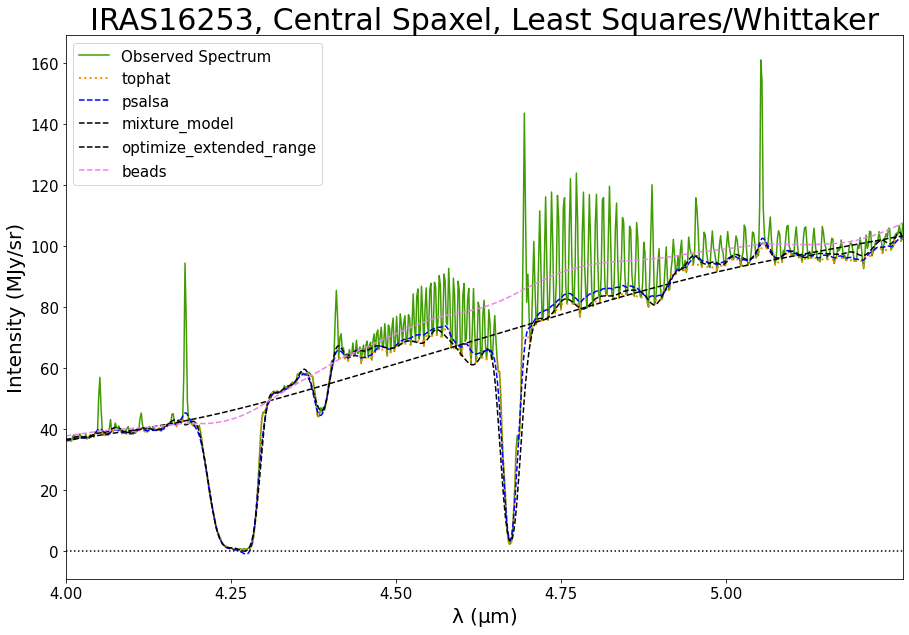

In [2]:
#testing templates and different interpolation schemes from pybaselines
from pybaselines import Baseline, utils

#make a figure to plot various locations on an image
fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes

#read in some data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits']
protostar_ind = 0 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

# extracting spectra
central_sources = [(48,46), (44,43), (46, 48), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...
flux_1pix = cube[:, central_sources[protostar_ind][0], central_sources[protostar_ind][1]][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
ax.plot(wave, flux_1pix, color='xkcd:grassy green', label='Observed Spectrum') #plot observation here!

#compute baseline with pybaselines
'''NOTES
Seems like the best ones per category are 
(whittaker) arpls with diff_order=3 or maybe psalsa (but tougher to tune), 
(morphological) jbcd or mwmv or tophat or ...imor with half_window=1 (too many parameters), 
(spline) maybe mixture_model or pspline_psalsa 
(smoothing), ria or ipsa
(classification), ???
(optimizer and misc) potential for solving for an actual baseline...
'''
baseline_fitter = Baseline(wave, check_finite=False)

#summary of best...
# # bkg_3 = baseline_fitter.arpls(flux_1pix, lam=0.05, diff_order=3)[0]
# # ax.plot(wave, bkg_3, label='arpls', linestyle='-') #baseline
# bkg_1 = baseline_fitter.jbcd(flux_1pix, half_window=3,alpha=100, diff_order=2)[0]
# bkg_5 = baseline_fitter.mwmv(flux_1pix, half_window=2, smooth_half_window=2)[0]
# ax.plot(wave, bkg_5, label='Moving Window at Min Val', linestyle='-', color='red') #baseline
# ax.plot(wave, bkg_1, label='Correcting and Denoising Least Squares', linestyle='-.', color='blue') #baseline
# # bkg_1 = baseline_fitter.ria(flux_1pix, sigma_scale=0.004, half_window=1)[0]
# bkg_4 = baseline_fitter.ipsa(flux_1pix, half_window=4)[0]
# # ax.plot(wave, bkg_1, label='ria', linestyle='--', color='black') #baseline
# ax.plot(wave, bkg_4, label='Iterative Polynomial Smoothing', linestyle='--', color='black') #baseline

#morphological
bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]
# bkg_1 = baseline_fitter.jbcd(bkg_top, half_window=10,alpha=1)[0]
# bkg_3 = baseline_fitter.imor(bkg_top, half_window=1)[0]
# bkg_4 = baseline_fitter.rolling_ball(bkg_top, half_window=10)[0]
# bkg_5 = baseline_fitter.mwmv(bkg_top, half_window=4)[0]
ax.plot(wave, bkg_top, color='darkorange', label='tophat', linestyle=':',lw=2) #baseline
# ax.plot(wave, bkg_3, color='cyan', label='Improved Morphological', linestyle='-.') #baseline
# ax.plot(wave, bkg_4, color='violet', label='rolling_ball', linestyle='--') #baseline
# ax.plot(wave, bkg_5, color='gray', label='Moving Window at Min Val', linestyle='-') #baseline
# ax.plot(wave, bkg_1, 'black', label='Correcting and Denoising Least Squares', linestyle='--') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Morphological', fontsize=30)

#whittaker
# bkg_1 = baseline_fitter.drpls(flux_1pix, lam=1000, eta=0.99)[0]
bkg_2 = baseline_fitter.aspls(flux_1pix, lam=1e4)[0]
# bkg_3 = baseline_fitter.arpls(flux_1pix, lam=1000, diff_order=3)[0]
bkg_4 = baseline_fitter.psalsa(flux_1pix, lam=10, p=0.1, k=50)[0]
# ax.plot(wave, bkg_1, 'black', label='drpls', linestyle='--') #baseline
# ax.plot(wave, bkg_2, 'purple', label='aspls', linestyle=':') #baseline
# ax.plot(wave, bkg_3, 'red', label='arpls', linestyle='-.') #baseline
ax.plot(wave, bkg_4, color='blue', label='psalsa', linestyle='--') #baseline
ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Least Squares/Whittaker', fontsize=30)

#spline
bkg_1 = baseline_fitter.mixture_model(flux_1pix, lam=0.001, num_knots=160)[0]
# bkg_3 = baseline_fitter.pspline_arpls(flux_1pix, lam=0.0001, diff_order=3, num_knots=160)[0]
# bkg_4 = baseline_fitter.pspline_psalsa(flux_1pix, lam=0.01, k=10, num_knots=300)[0]
ax.plot(wave, bkg_1, 'black', label='mixture_model', linestyle='--') #baseline
# ax.plot(wave, bkg_3, 'red', label='pspline_arpls', linestyle='-.') #baseline
# ax.plot(wave, bkg_4, color='cyan', label='pspline_psalsa', linestyle='--') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Splining', fontsize=30)

#smoothing
# bkg_1 = baseline_fitter.ria(bkg_top, sigma_scale=0.01, half_window=10)[0]
# bkg_2 = baseline_fitter.snip(bkg_top, max_half_window=4)[0]
# bkg_4 = baseline_fitter.ipsa(bkg_top, half_window=10)[0]
# ax.plot(wave, bkg_1, 'black', label='ria', linestyle='--') #baseline
# ax.plot(wave, bkg_2, 'red', label='snip', linestyle=':') #baseline
# ax.plot(wave, bkg_4, color='blue', label='ipsa', linestyle='-.') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Smoothing', fontsize=30)

#classification
# bkg_1 = baseline_fitter.cwt_br(bkg_top, poly_order=8, num_std=10, min_length=1, scales=10)[0]
# bkg_2 = baseline_fitter.fabc(bkg_top, lam=0.1, scale=5, num_std=4, diff_order=1)[0]
# ax.plot(wave, bkg_1, 'black', label='cwt_br', linestyle='--') #baseline
# ax.plot(wave, bkg_2, '^', label='fabc', linestyle=':') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Classifiers', fontsize=30)

#optimizer
bkg_1 = baseline_fitter.optimize_extended_range(bkg_top, sigma_scale=1, min_value=7, max_value=9, method='aspls')[0]
# print(baseline_fitter.optimize_extended_range(bkg_top, sigma_scale=0.1, min_value=3, max_value=10, method='aspls')[1])
bkg_4 = baseline_fitter.beads(flux_1pix, smooth_half_window=2,  asymmetry=0.25, lam_0=10)[0]
ax.plot(wave, bkg_1, 'black', label='optimize_extended_range', linestyle='--') #baseline
ax.plot(wave, bkg_4, color='violet', label='beads', linestyle='--') #baseline
# ax.set_title(cube_file_list[protostar_ind].split('/')[0] + ', Central Spaxel, Optimizers and Misc', fontsize=30)

#formatting plot
# ax.plot(wave, baseline_list, color='xkcd:twilight blue', label='Line Emission') #data
# ax.set_yscale('log') #if you would like to set a log scale
ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
ax.legend(loc='best', fontsize=15)
ax.set_xticks(np.arange(3, 5.25, 0.25))
ax.set_xlim(4, np.max(wave))
# ax.set_ylim(np.min(np.nan_to_num(flux_1pix))*30,np.max(np.nan_to_num(flux_1pix))*0.8)
# ax.set_ylim(0,1000)
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=20)
ax.set_ylabel('Intensity (MJy/sr)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
# fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

# Applying Baseline Techniques

In [14]:
#setting up some initial lists

from pybaselines import Baseline, misc #, utils
from scipy.signal import medfilt, savgol_filter

#used for plotting
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] 

#the original data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits']

#derived data or cubes
protostar_substr = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
absorb_emiss_path = 'Extended_CO_CO2/CO_Absorption_Emission_Maps/'
absorb_emiss_cube_list = [glob(absorb_emiss_path + i + '*cube*.fits')[0].replace('\\', '/') for i in protostar_substr]
absorb_emiss_txt_list = [glob(absorb_emiss_path + i + '*txt')[0].replace('\\', '/') for i in protostar_substr]

# central_sources = [(46.57459417809592, 45.12978229),  (46.73250708463416, 43.13112798), \
                #    (46.47088442936513, 46.6279981), (41.71119797770727, 43.61467905), \
                    # (43.38667807448542, 43.15705917)]

In [4]:
# an alternative approach partially by you.com chatbot AI - would need editing to functionalize, but would be very convenient
# wave_cutoff_inds = np.array([np.abs(wave - i).argmin() for i in wave_cutoff_list])
# wave_sectioned = np.split(wave, wave_cutoff_inds)
# flux_sectioned =  np.split(flux_1pix, wave_cutoff_inds)
# baseline_list = np.array([baseline_fitter.jbcd(np.split(bkg_top, wave_cutoff_inds)[i], half_window=smooth_list[i],alpha=alpha_list[i])[0] for i in range(len(wave_cutoff_inds))]).flatten()

# baseline_list = np.zeros_like(wave)
# for i in range(len(wave_cutoff_list) - 1):
#     idx = (wave >= wave_cutoff_list[i]) & (wave < wave_cutoff_list[i+1])
#     mask = np.where(idx)[0]
#     baseline_fitter = Baseline(wave[mask], check_finite=False)
#     baseline = baseline_fitter.jbcd(bkg_top[mask], half_window=smooth_list[i], alpha=alpha_list[i])[0]
#     baseline_list[mask] = baseline

#yet another alternative where we're trying to fit each line individually for absorption or emission..
#     #absorption, colored as blue
    #     if line_absorb_emiss_match == -1: 
    #         baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.99999, lam=1e6)[0]
    #     #emission, colored as yellow
    #     elif line_absorb_emiss_match == +1: 
    #         baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.00001, lam=1e6)[0]
    #     #neither, but the neighbors match so we know it's probably the same as the others
    #     elif line_absorb_emiss_match == 0 and cube_absorb_emiss[line-1, int(source_coords[i][0]), int(source_coords[i][1])] \
    #                                                 == cube_absorb_emiss[line+1, int(source_coords[i][0]), int(source_coords[i][1])]: 
    #         if cube_absorb_emiss[line-1, int(source_coords[i][0]), int(source_coords[i][1])] == -1:
    #             baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.99999, lam=1e6)[0]
    #         elif cube_absorb_emiss[line-1, int(source_coords[i][0]), int(source_coords[i][1])] == +1:
    #             baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.00001, lam=1e6)[0]
    #     #neither, but we can't come up with a good basis to guess off of, maybe do it in the middle?
    #     else: 
    #         #could do tophat, pspline, asls, whatever gets a smooth curve or through the middle of the noise
    #         baseline = baseline_fitter.pspline_asls(line_flux_match, p=0.01, lam=1e6)[0] # [np.nan]*len(line_flux_match) # baseline_fitter.tophat(line_flux_match, half_window=3)[0]
        
    #     #then store in a list
    #     co_baseline_list = np.concatenate((co_baseline_list, baseline))
    #     co_wave_list = np.concatenate((co_wave_list, wave[line_wave_idx-2 : line_wave_idx+2])) #finding associated wavelengths for interpolation later

    #now we need to reprocess and smooth this baseline list
    #first attempt an interpolation to get back to the original grid we had
    # f_interp = interp1d(co_wave_list, co_baseline_list, assume_sorted = False)
    # co_wave_interp = wave[(wave > co_refs_txt[0][1]) * (wave < co_refs_txt[-2][1])]

    # baseline_interpolated = f_interp(co_wave_interp) #from scipy

    # #not smoothed enough, so then we refit the new baseline (generally getting the correct envelope or initial guess)
    # baseline_fitter = Baseline(co_wave_interp, check_finite=False)
    # baseline_smoothed = baseline_fitter.jbcd(baseline_interpolated, half_window=4, alpha=100)[0]



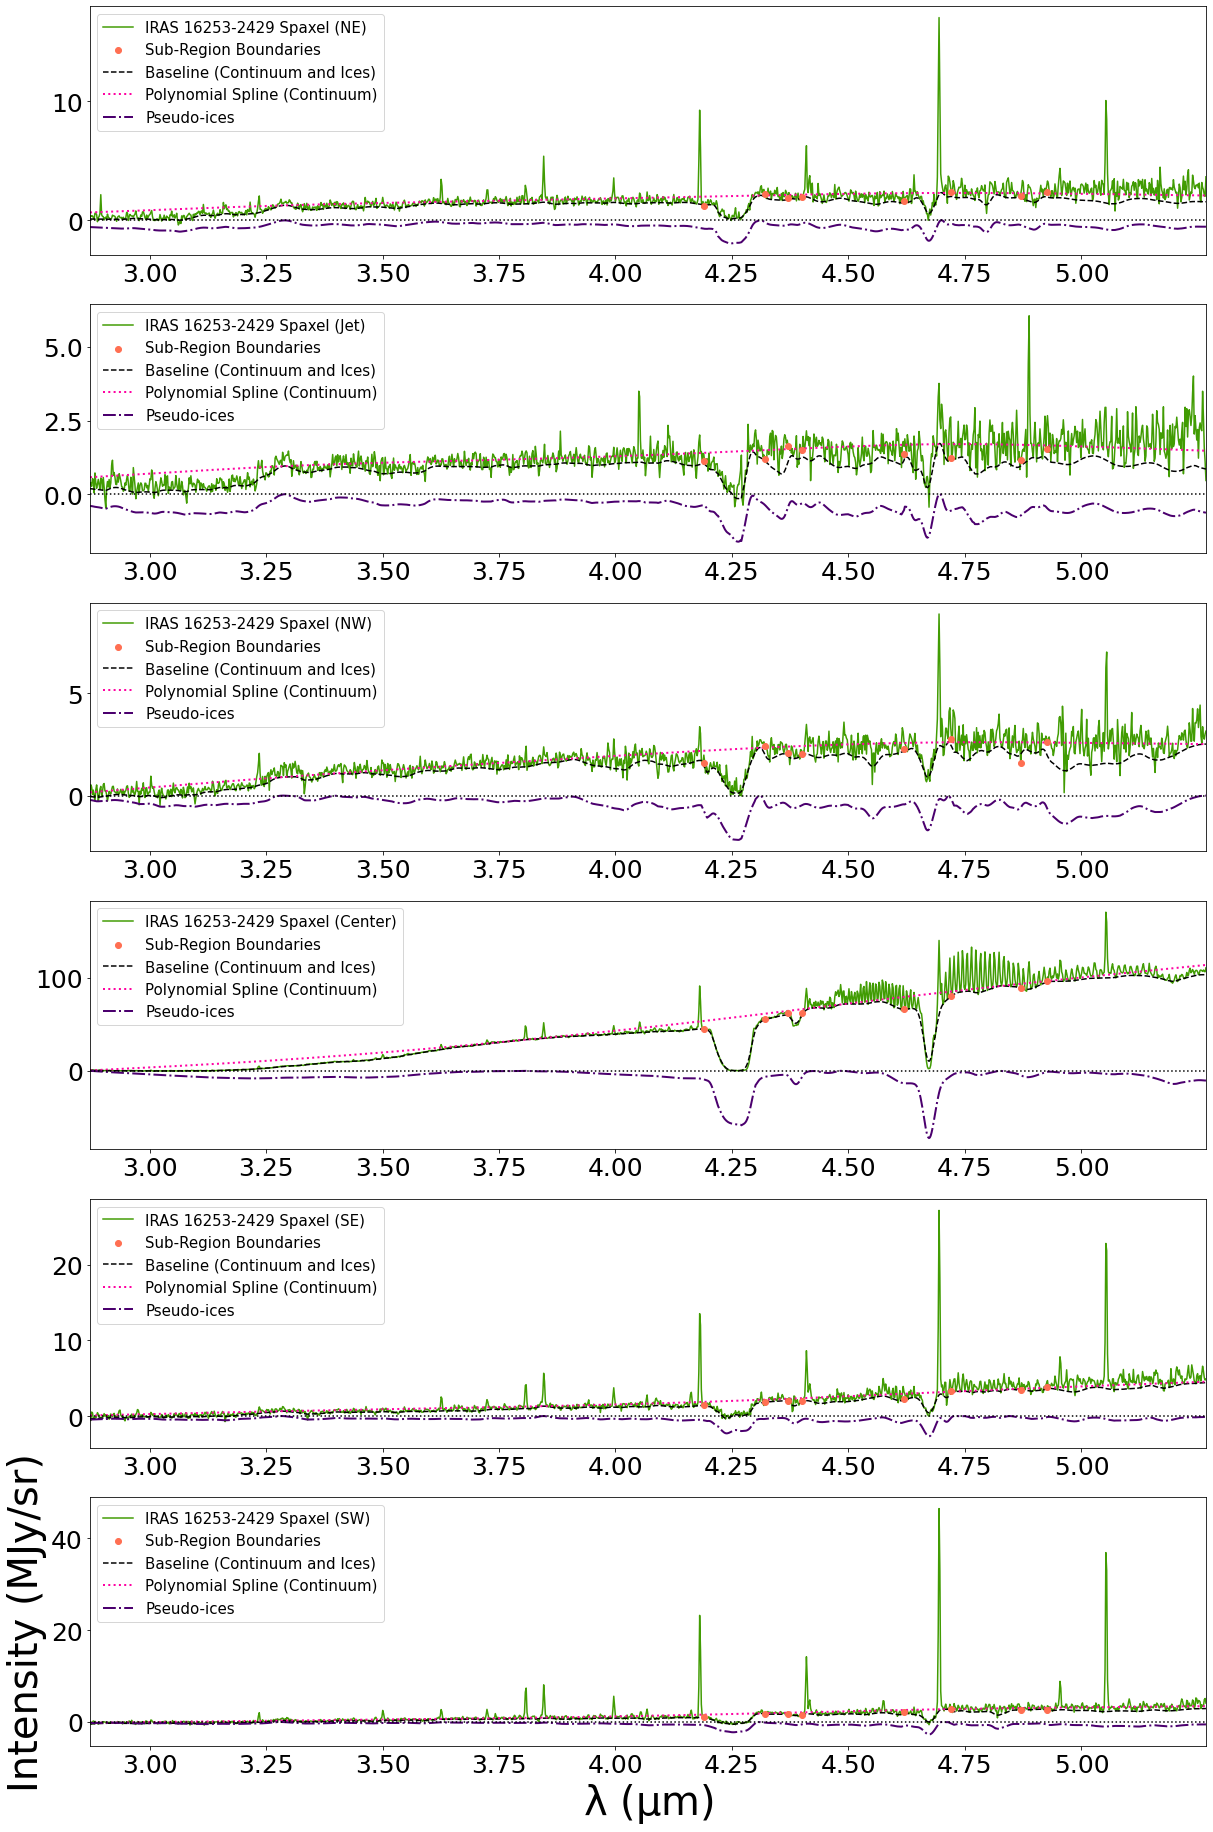

In [23]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 0 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(64, 30),  (70, 37), (74, 52), (48, 47), (33, 49), (37, 64)] #note these coordinates can be flipped relative to the image reader
source_labels = ['NE', 'Jet', 'NW', 'Center', 'SE', 'SW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.925])
smooth_list = [1, 1, 10, 1, 5, 3, 5, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(20,32), nrows=6) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    # baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(np.min(wave), np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

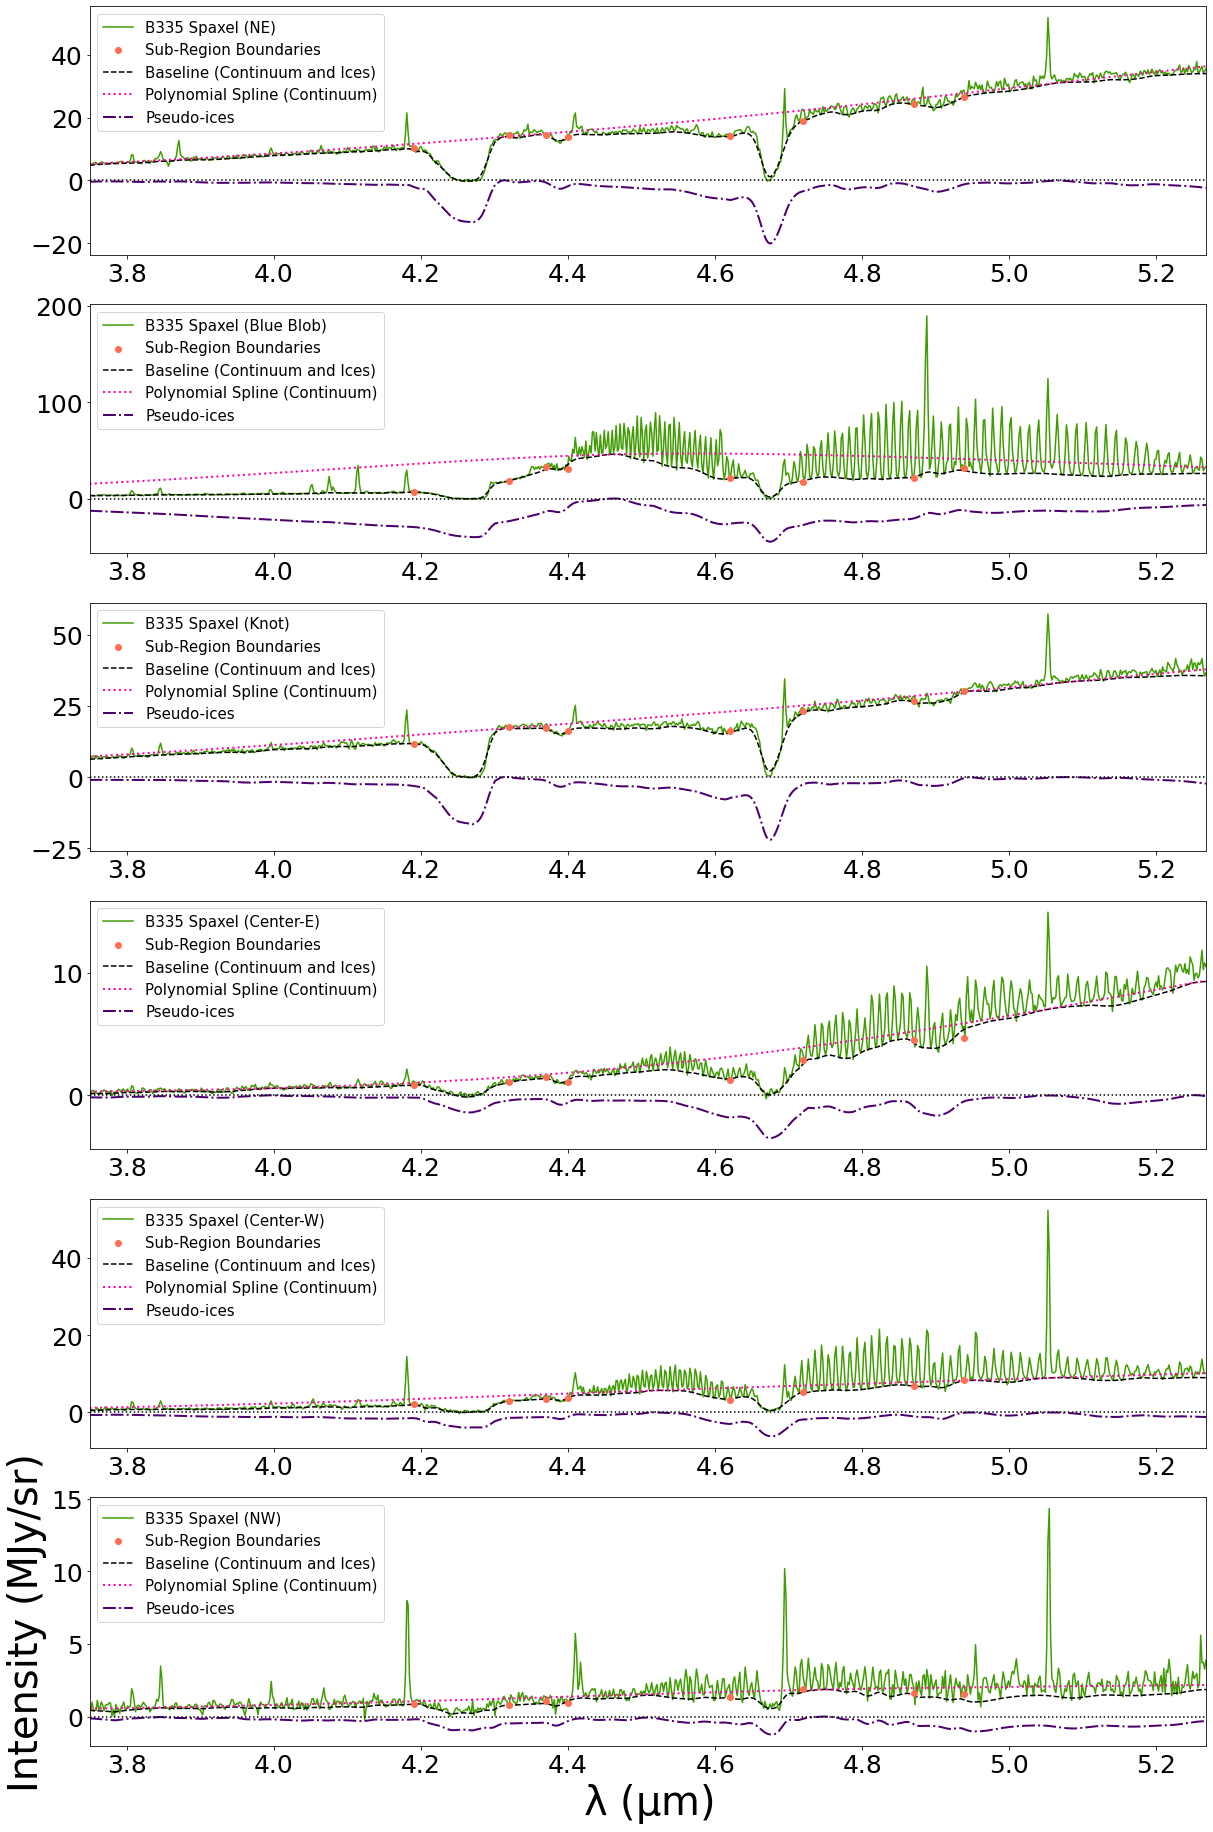

In [123]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 1 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(55, 22),  (45, 28), (36, 20), (46, 45), (42, 54), (52, 72)]
source_labels = ['NE', 'Blue Blob', 'Knot', 'Center-E', 'Center-W', 'NW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 5, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(20,32), nrows=6) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    # baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(3.75, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

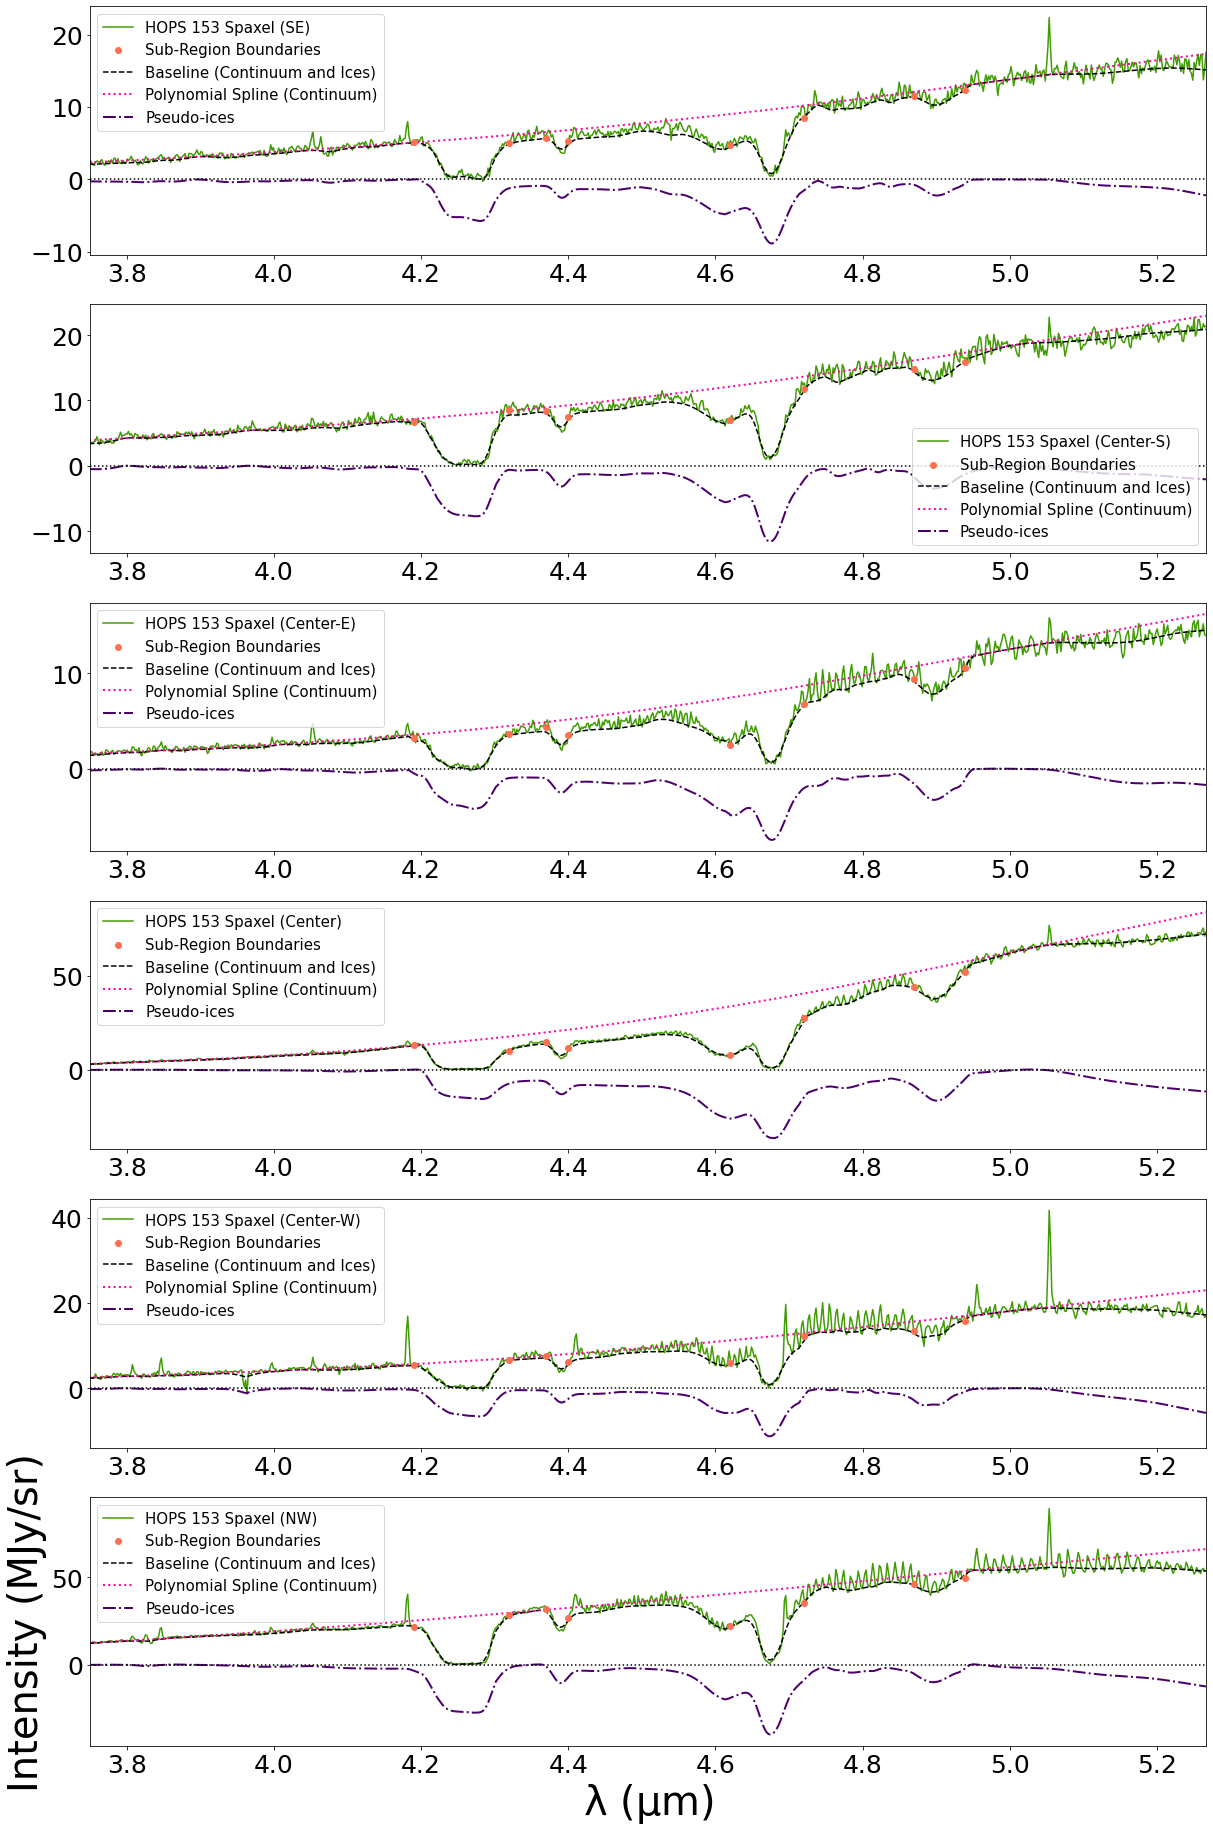

In [124]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 2 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(39, 29),  (37, 43), (43, 47), (48, 47), (49, 53), (56, 49)]
source_labels = ['SE', 'Center-S', 'Center-E', 'Center', 'Center-W', 'NW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 1, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(20,32), nrows=6) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=2e2, p=0.99, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(3.75, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

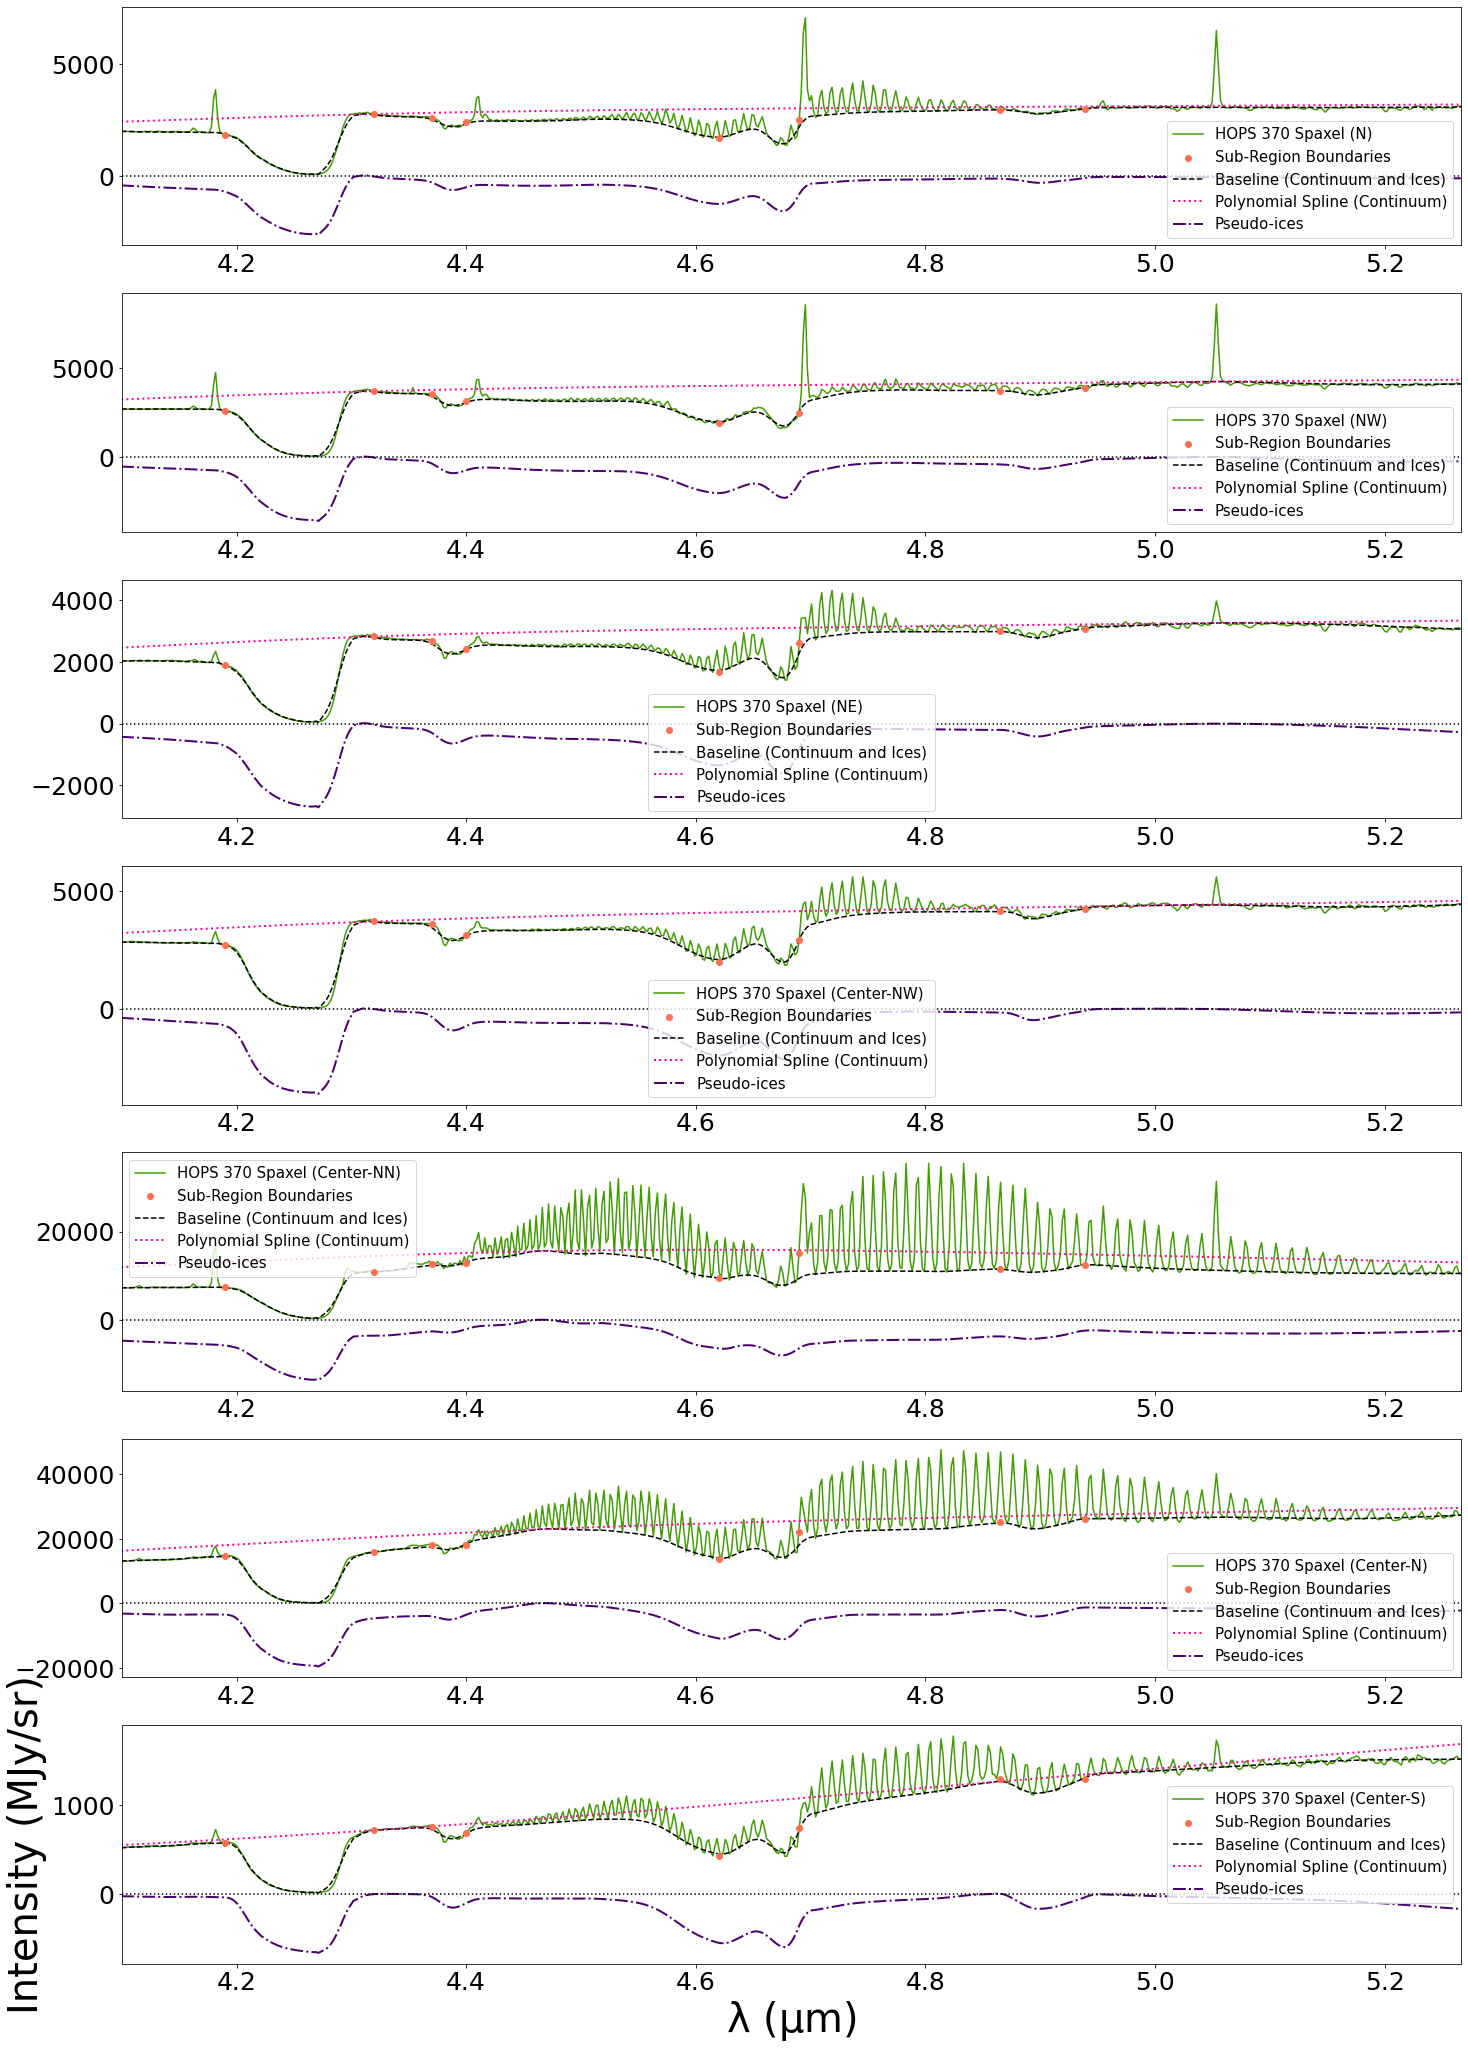

In [122]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 3 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(70, 42),  (66, 56), (61, 32), (57, 51), (53, 42), (47, 42), (41, 38)]
source_labels = ['N', 'NW', 'NE', 'Center-NW', 'Center-NN', 'Center-N', 'Center-S']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.69, 4.865, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 10, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 1, 1000, 100] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]


#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(24,36), nrows=7) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(4.1, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

0 1 original version
0 2 original version
0 3 original version
0 4 absorption, new way
0 5 absorption, new way
0 6 absorption, new way
0 7 absorption, new way
1 1 original version
1 2 original version
1 3 original version
1 4 emission, old way
1 5 emission, old way
1 6 emission, old way
1 7 absorption, new way
2 1 original version
2 2 original version
2 3 original version
2 4 absorption, new way
2 5 neither, unsure
2 6 emission, old way
2 7 absorption, new way
3 1 original version
3 2 original version
3 3 original version
3 4 emission, old way
3 5 emission, old way
3 6 emission, old way
3 7 emission, old way
4 1 original version
4 2 original version
4 3 original version
4 4 emission, old way
4 5 neither, unsure
4 6 emission, old way
4 7 neither, unsure
5 1 original version
5 2 original version
5 3 original version
5 4 emission, old way
5 5 emission, old way
5 6 emission, old way
5 7 emission, old way
6 1 original version
6 2 original version
6 3 original version
6 4 absorption, new way

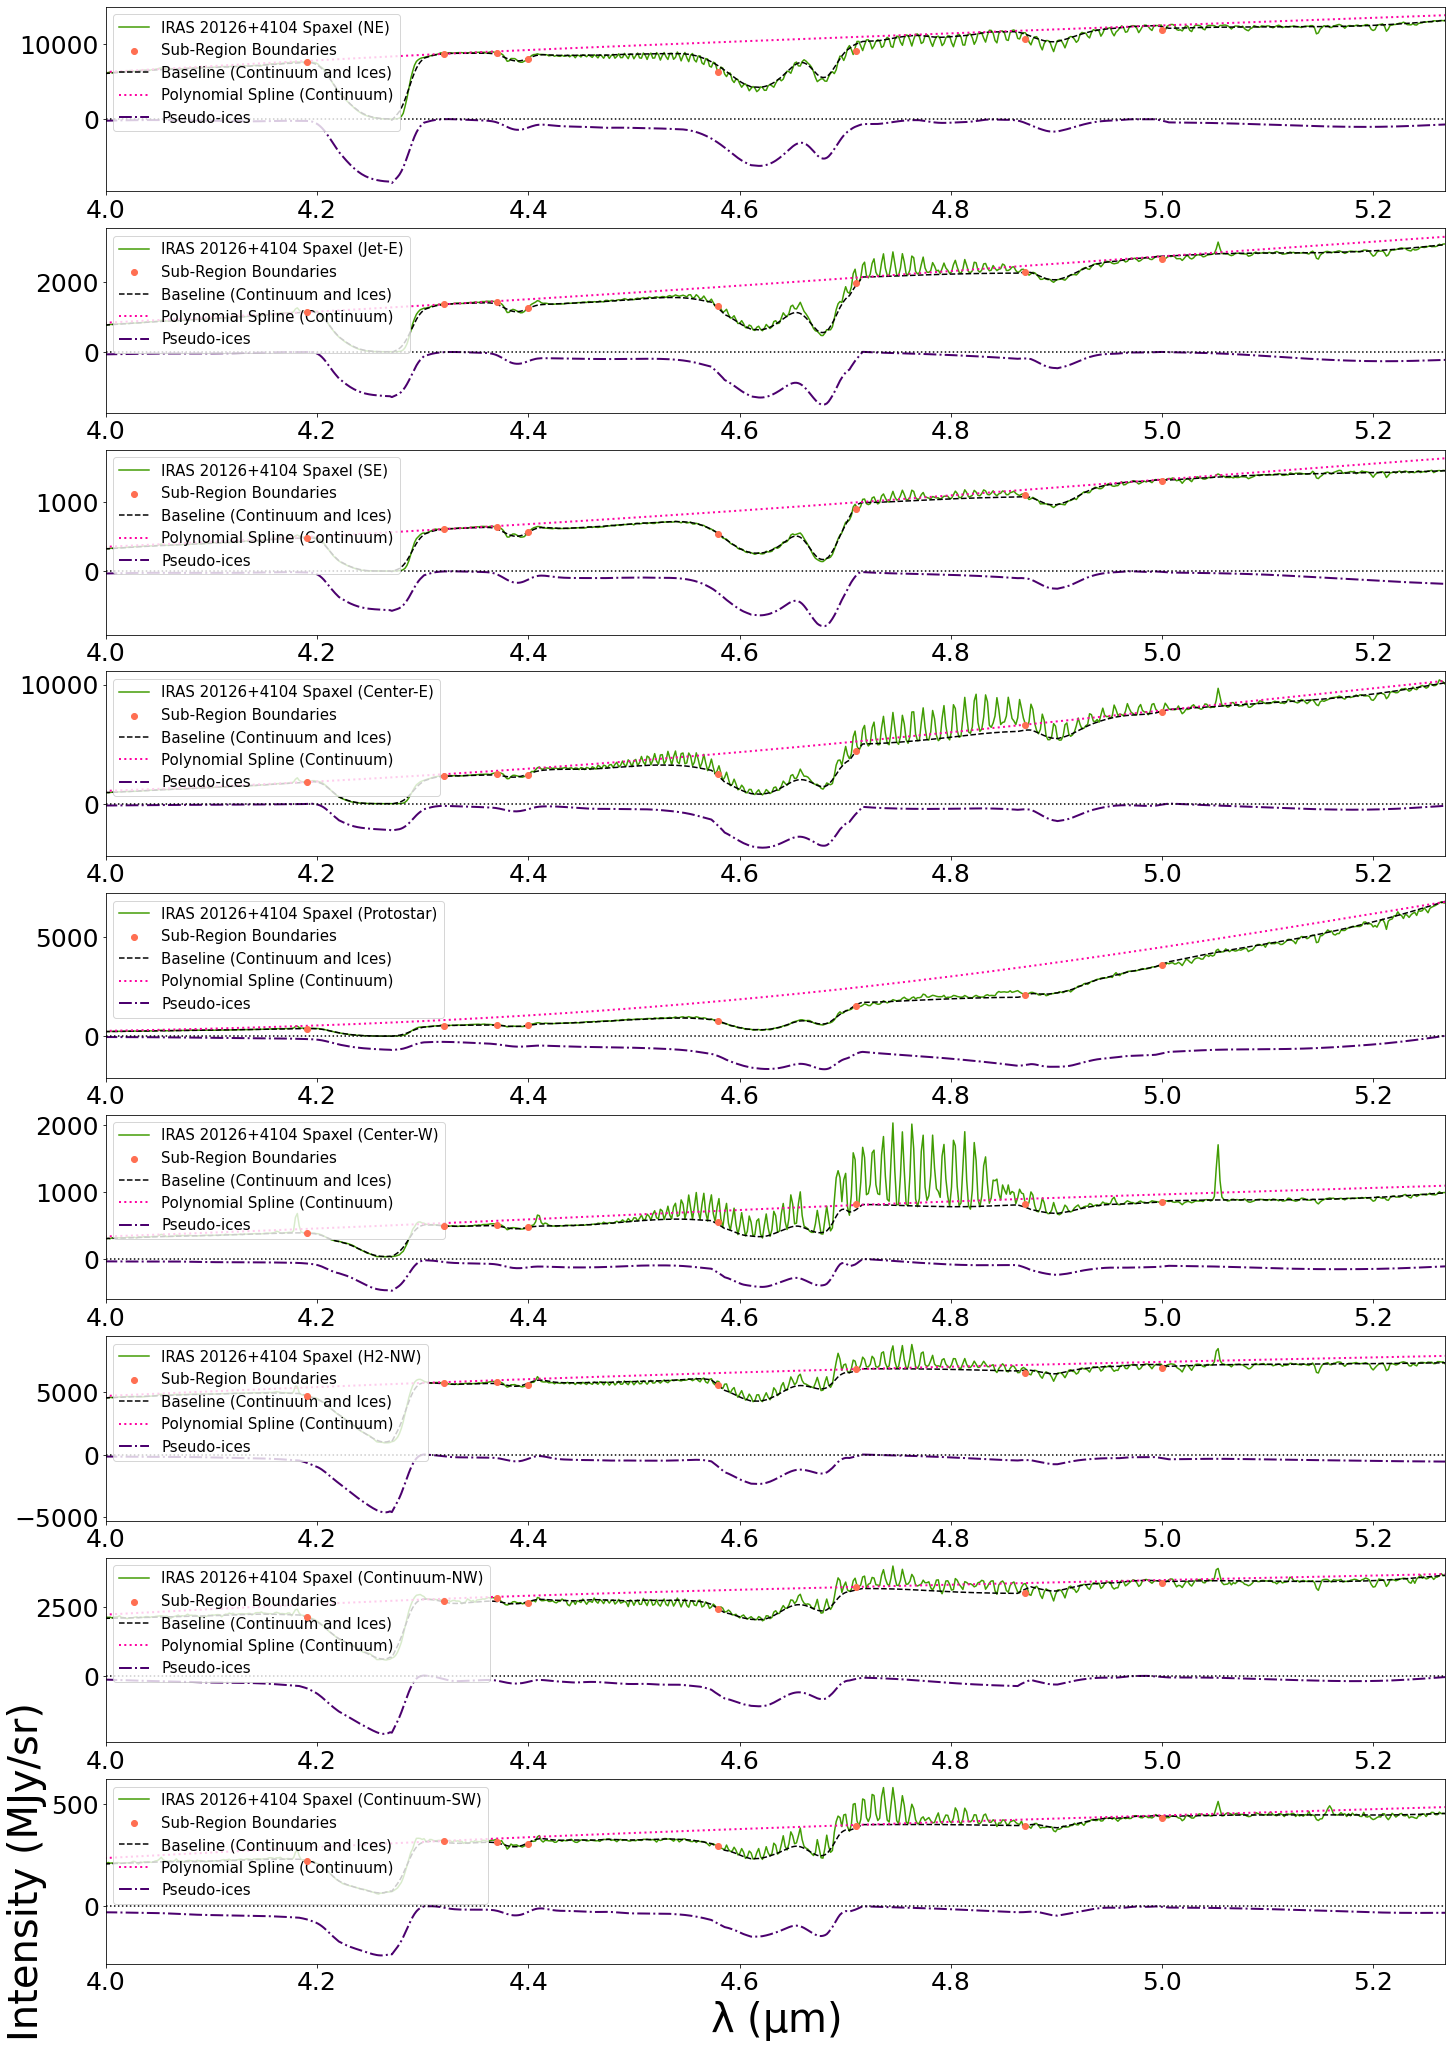

In [191]:
#testing an initial filter + interpolation for baselines

#read in some data
protostar_ind = 4 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_ind])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_ind], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(45,25),  (36,33), (27,34), (44,44), (47,49), (51,54), (60,63), (69,66), (76,52)]
source_labels = ['NE', 'Jet-E', 'SE', 'Center-E', 'Protostar', 'Center-W', 'H2-NW', 'Continuum-NW', 'Continuum-SW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.58, 4.71, 4.87, 5.0]) # 4.939
wave_cutoff_mod_list = [] #updated version of the above list...
smooth_list = [1, 1, 10, 1, 5, 3, 15, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 0.1, 7, 1] #regularization parameter (relative levels of noise and signal)

#then set up a figure to loop over
fig, ax_list = plt.subplots(figsize=(24,36), nrows=9) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(ax_list)):
    ax = ax_list[i]

    # extracting spectra
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    wave_cutoff_mod_list.append(wave_cutoff_list[0]) #just so we're consistent with the start and ending points
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        #take region of spectrum
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)

        #loop through many CO spectral lines to determine each individual baseline 
        if wave_cutoff_list[cutoff_ind] < 4.41: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind])
            baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        else:
            # before computing the mode, we want to actually modify our breakpoints...

            '''
            List = region +/- 0.1 around that point
            now move the break point to a spot between -1 to +1 or +1 to -1 (signifying the absorption to emission switchover)
            ...maybe see if that spot is guaranteed by having +/- 10 array elements on either side having a constant sign?
            THIS spot gets plotted on the spectrum, then we can continue...
            ''' 
            #search for CO lines in the wavelength region we are concerned with
            #first, mask the text file array of lines using the cutoff points
            co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind-1]) & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind]))[0]
            wave_cutoff_mod_list.append(wave_cutoff_list[cutoff_ind] +/- 0.1 '???')

            #first we find corresponding matched lines by wavelength from our co_txt and the set's mode in cube_absorp_emiss
            line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, int(source_coords[i][0]), int(source_coords[i][1])]
            vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
            absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

            #now using the mode to pick and compute the correct baseline
            if absorb_emiss_mode == 1: #emission, do old way
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
            elif absorb_emiss_mode == -1: #absorption, change slightly
                baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], p=0.9, lam=1e1)[0]
                # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
            else: #default to original if we can't figure anything else out...
                # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1


    #if edge case at end, do it by hand
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    wave_cutoff_mod_list.append(wave_cutoff_list[-1]) #for consistency
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    # now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_mod_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(co_wave_list, co_baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    # formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    baseline_fitter = Baseline(wave, check_finite=False)
    ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #formatting plot
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(4, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='upper left', fontsize=15)
    if i == len(ax_list) - 1:
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

(4.45, 5.3876608595271716)

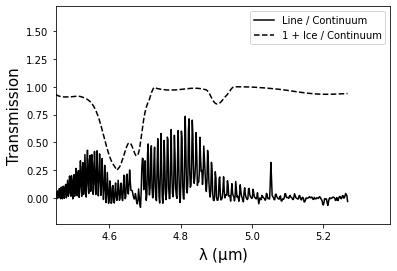

In [66]:
#separately plotting the transmission curve to check
plt.plot(wave, (flux_1pix - baseline_list)/(ice_list), 'k-', label='Line / Continuum') #if interested in line to continuum ratio
plt.plot(wave, 1 + (baseline_list - ice_list)/(ice_list), 'k--', label='1 + Ice / Continuum') #if interested in ice to continuum ratio

#formatting
plt.legend()
plt.ylabel('Transmission', fontsize=15)
plt.xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=15)
# plt.ylim(0,)
plt.xlim(4.45,)


In [3]:
#a new fits file to be saved, maybe viewed in DS9
# may need to modify the function for a particular image, but generally useful
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution...
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name can be the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''
    
    #just setup an fits HDU from the data
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
        #saving the file
    #         name_fixfit = name[:-3] + 'fits'
#         new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
#         hdul.writeto(save_path+new_filename, overwrite=True)
    hdul.writeto(save_path+name, overwrite=True)     
    return (save_path+name)

In [4]:
# Let's try making a baseline image while looping through wavelengths
from pybaselines import Baseline, utils
from scipy.signal import medfilt, savgol_filter

#for now, defining the paths by hand since in theory we only have 5 to do
#at some point might help to swap to glob.glob if we use different directory structure
#I opt to store in in individual folders to catch name issues early...
protostar_folders = ['IRAS16253/', 'B335/', 'HOPS153/', 'HOPS370/', 'IRAS20126/']
cube_file_list = [glob(i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

#params to smooth out data
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 10, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 1, 1] #regularization parameter (relative levels of noise and signal)
param_secondtolast = [2, 7]
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that

#go through all files
for protostar_count, filepath in enumerate(cube_file_list):
    #open and read a data file
    protostar_id = filepath.split('/')[0] # for reference later when saving files
    hdul = fits.open(filepath)
    jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
    jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
    jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]

    #figuring out units
    photometric_head = hdul[1].header
    delta_lambda = photometric_head['CDELT3'] #in microns ?
    pixel_area = photometric_head['PIXAR_SR'] # in sr
    '''
    pixel units for JWST are MJy/sr, the sr card is PIXAR_SR, ignore for now
    then MJy to cgs is 1e6*1 Jy/sr = 1e6 * 1e-23 erg/s/cm^2/spectral bandwidth in frequency, Hz per sr
    
    that is per frequency bandwidth! must multiply by it...
    since we only have the frequency band, we can convert by c = lam * nu, bandwidth=delta_nu = c/lam^2 * delta_lambda
    and then we must multiply by this bandwidth: have 1e6 * 1e-23 * c/lam^2 * delta_lambda * sr
    
    c units must change for what wavelength we use...here we use microns, so c in micron/sec is 3e8 m/s * (1e6 mic/m)
    so c = ~3e14
    
    and to prep in the loop, for each cube we will grab the delta_lambda and the pixel_area in sr
    '''
    cube_units = 1e6 * 1e-23 * 3e14/(jwst_cube_wave[:, None, None])**2. * delta_lambda * pixel_area 

    #set up arrays to be read in...
    baseline_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
    resid_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
    cont_arr = np.zeros((jwst_data.shape))
    ice_arr = np.zeros((jwst_data.shape))
    transmission_arr = np.zeros((jwst_data.shape))
    tau_ice_arr = np.zeros((jwst_data.shape))

    #compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
    # baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
    baseline_fitter_global = Baseline(jwst_cube_wave, check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
    #by explicit loops
    for i in range(jwst_data.shape[1]):
        for j in range(jwst_data.shape[2]):
            #access cube to separate out an initial estimate for the baseline
            bkg_top = baseline_fitter_global.tophat(jwst_data[:,i,j], half_window=3)[0]

            # baseline_alpha = stacked_coeffs[len(unres_wavelengths):, i, j] #need to gather our parameter, alpha
            baseline_list = np.array([])
            for cutoff_ind in range(len(wave_cutoff_list)): #
                #if between two values and not at the edge cases
                if cutoff_ind != 0 and cutoff_ind != len(wave_cutoff_list)-1:
                    idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
                    cutoff_mask = np.where(idx)[0] #determine mask between two values
                #if edge case at start
                elif cutoff_ind == 0:
                    cutoff_mask = jwst_cube_wave < wave_cutoff_list[cutoff_ind] #define mask up to first marker
                #if edge case at end, need to do this twice! (as I have it set up here at least)
                elif cutoff_ind == len(wave_cutoff_list)-1:
                    #first, do the case I'd otherwise miss here 
                    idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
                    cutoff_mask = np.where(idx)[0] #determine mask between two values
                    baseline_fitter_local = Baseline(jwst_cube_wave[cutoff_mask], check_finite=True)
                    baseline = baseline_fitter_local.jbcd(bkg_top[cutoff_mask], half_window=param_secondtolast[0], alpha=param_secondtolast[1])[0] #this is the actual baseline fitting step
                    baseline_list = np.concatenate((baseline_list, baseline))

                    #then cutoff at end
                    cutoff_mask = jwst_cube_wave > wave_cutoff_list[cutoff_ind] #define mask past last marker

                #compute baseline
                baseline_fitter_local = Baseline(jwst_cube_wave[cutoff_mask], check_finite=True)
                baseline = baseline_fitter_local.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind], alpha=alpha_list[cutoff_ind])[0] #this is the actual baseline fitting step
                baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

            #now trying to filter around our control or anchor points
            for cutoff_ind in range(len(wave_cutoff_list)):
                idx = ( jwst_cube_wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( jwst_cube_wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
                idx_mask = np.where(idx)[0] #making mask
                # baseline_list[idx_mask] = medfilt(baseline_list[idx_mask], kernel_size=11)
                baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

            #storing data into arrays!!!
            baseline_fit_arr[:,i,j] = baseline_list 
            resid_arr[:,i,j] = jwst_data[:,i,j]  - baseline_list   
            cont_arr[:,i,j] = baseline_fitter_global.pspline_asls(baseline_list, lam=1e2, p=0.9999)[0]  
            ice_arr[:,i,j] = baseline_list - cont_arr[:,i,j] 
            transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
            tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])    
        

    #tests to check shapes are correct
    # print('JWST: ', jwst_data.shape, ' Splined baseline Cube: ', baseline_fit_arr.shape, ' Summed baseline: ', baseline_sum_arr.shape,)
    #saving baseline as cube, not summed, with MJy/sr
    astropy_cube_units = u.MJy/u.sr #need to define units

    #saving baseline as cube, not summed, with MJy/sr
    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    cube = SpectralCube(data=baseline_fit_arr*astropy_cube_units, wcs=jwst_cube.wcs)
    # cube = cube.with_spectral_unit(u.um)
    cube_savepath = 'Baseline/'
    cube_name = protostar_id + '_NIRspec_cube_tophat_jcbd.fits'
    cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
    print('Saved: ', cube_savepath+cube_name)

    #saving baseline_subtracted cube, with MJy/sr
    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    nocont_cube = SpectralCube(data=resid_arr*astropy_cube_units, wcs=jwst_cube.wcs)
    # nocont_cube = cube.with_spectral_unit(u.um)
    nocont_cube_savepath = 'Baseline_Subtracted/'
    nocont_cube_name = protostar_id + '_NIRspec_cube_basefit_tophat_jcbd.fits'
    nocont_cube.write(nocont_cube_savepath+nocont_cube_name, format='fits', overwrite=True)
    print('Saved: ', nocont_cube_savepath+nocont_cube_name)

    #saving baseline as cube, not summed, with cgs units
    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    cube = SpectralCube(data=cont_arr*astropy_cube_units, wcs=jwst_cube.wcs)
    cube_savepath = 'Continuum/'
    cube_name = protostar_id + '_NIRspec_cube_pspline_asls_cont.fits'
    cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
    print('Saved: ', cube_savepath+cube_name)

    #ways to average baselines and also develope a header for relevant usage
    continuum_sum_arr = np.sum(cube_units* cont_arr, axis=0)
    continuum_med_arr = np.median(cube_units * cont_arr, axis=0)
    continuum_mean_arr = np.mean(cube_units * cont_arr, axis=0)
    continuum_header = jwst_cube.header #need to edit header a bit
    continuum_header['BUNIT'] = 'erg cm-2 s-1 sr-1' 
    continuum_header['CUNIT3'] = 'um'
    continuum_header['HISTORY'] = 'The following steps apply: converted to cgs units (erg/s/cm^2/sr). Then baseline is averaged accordingly.'

    #saving summed cube...need to note in name...
    savepath = 'Continuum/' #set folder
    name = protostar_id + '_NIRspec_Continuum_sum'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
    fits_path = fits_saver(continuum_sum_arr, continuum_header, name, savepath) #saving
    print('Saved: ', fits_path) #I use to confirm file has right path

    #saving median cube...need to note in name...
    savepath = 'Continuum/' #set folder
    name = protostar_id + '_NIRspec_Continuum_med'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
    fits_path = fits_saver(continuum_med_arr, continuum_header, name, savepath) #saving
    print('Saved: ', fits_path) #I use to confirm file has right path

    #saving mean cube...need to note in name...
    savepath = 'Continuum/' #set folder
    name = protostar_id + '_NIRspec_Continuum_mean'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
    fits_path = fits_saver(continuum_mean_arr, continuum_header, name, savepath) #saving
    print('Saved: ', fits_path) #I use to confirm file has right path

    #given continuum, compute ices

    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    cube = SpectralCube(data=ice_arr*astropy_cube_units, wcs=jwst_cube.wcs)
    cube_savepath = 'Ices/'
    cube_name = protostar_id + '_NIRspec_cube_pspline_asls_ice.fits'
    cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
    print('Saved: ', cube_savepath+cube_name)

    #saving baseline as cube, not summed, could be with cgs units, but here is just a ratio...
    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    cube = SpectralCube(data=transmission_arr, wcs=jwst_cube.wcs)
    cube_savepath = 'Ices/'
    cube_name = protostar_id + '_NIRspec_cube_pspline_asls_transmission.fits'
    cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
    print('Saved: ', cube_savepath+cube_name)

    #saving baseline as cube, not summed, with cgs units
    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    cube = SpectralCube(data=tau_ice_arr, wcs=jwst_cube.wcs)
    cube_savepath = 'Ices/'
    cube_name = protostar_id + '_NIRspec_cube_pspline_asls_icetau.fits'
    cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
    print('Saved: ', cube_savepath+cube_name)

C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:102: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/IRAS16253_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/IRAS16253_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/IRAS16253_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/IRAS16253_NIRspec_Continuum_sum.fits
Saved:  Continuum/IRAS16253_NIRspec_Continuum_med.fits
Saved:  Continuum/IRAS16253_NIRspec_Continuum_mean.fits
Saved:  Ices/IRAS16253_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/IRAS16253_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/IRAS16253_NIRspec_cube_pspline_asls_icetau.fits


C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:102: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/B335_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/B335_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/B335_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/B335_NIRspec_Continuum_sum.fits
Saved:  Continuum/B335_NIRspec_Continuum_med.fits
Saved:  Continuum/B335_NIRspec_Continuum_mean.fits
Saved:  Ices/B335_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/B335_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/B335_NIRspec_cube_pspline_asls_icetau.fits


C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:102: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/HOPS153_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/HOPS153_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/HOPS153_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/HOPS153_NIRspec_Continuum_sum.fits
Saved:  Continuum/HOPS153_NIRspec_Continuum_med.fits
Saved:  Continuum/HOPS153_NIRspec_Continuum_mean.fits
Saved:  Ices/HOPS153_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/HOPS153_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/HOPS153_NIRspec_cube_pspline_asls_icetau.fits


C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:102: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/HOPS370_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/HOPS370_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/HOPS370_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/HOPS370_NIRspec_Continuum_sum.fits
Saved:  Continuum/HOPS370_NIRspec_Continuum_med.fits
Saved:  Continuum/HOPS370_NIRspec_Continuum_mean.fits
Saved:  Ices/HOPS370_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/HOPS370_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/HOPS370_NIRspec_cube_pspline_asls_icetau.fits


C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:102: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_37140\682632896.py:103: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/IRAS20126_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/IRAS20126_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/IRAS20126_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/IRAS20126_NIRspec_Continuum_sum.fits
Saved:  Continuum/IRAS20126_NIRspec_Continuum_med.fits
Saved:  Continuum/IRAS20126_NIRspec_Continuum_mean.fits
Saved:  Ices/IRAS20126_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/IRAS20126_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/IRAS20126_NIRspec_cube_pspline_asls_icetau.fits


In [5]:
#go through all files and note units for later...
for protostar_count, filepath in enumerate(cube_file_list):
    #open and read a data file
    protostar_id = filepath.split('/')[0] # for reference later when saving files
    hdul = fits.open(filepath)

    #figuring out units
    photometric_head = hdul[1].header
    delta_lambda = photometric_head['CDELT3'] #in microns ?
    pixel_area = photometric_head['PIXAR_SR'] # in sr

    cube_units = 1e6 * 1e-23 * 3e14 * delta_lambda 
    print(cube_units) 

5.370000028051437e-06
5.370000028051437e-06
5.370000028051437e-06
5.370000028051437e-06
5.370000028051437e-06


' after creating file, add to the header\n\nfile: 1D spectrum by Adam Rubinstein\nprotostar: IRAS 16253\nstat method: sum\naperture shape: square\naperture side length or diameter: 1 arcsec\nadditional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. \nadditional notes: centered using alma coordinates\n\n'

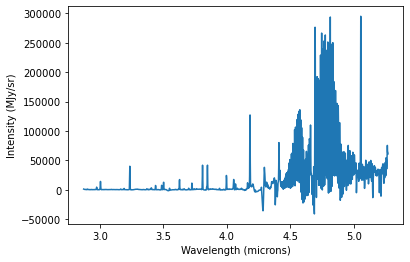

In [22]:
# Read in a 3-D IFU datacube of interest, and header
#first, note the path
protostar_folders = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
protostar_ind = 4
cube_file_list = [glob('Baseline_Subtracted/' + i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

# Read in a 3-D IFU datacube of interest, and header
#first, note the path
cube_file = cube_file_list[protostar_ind]
hdul = fits.open(cube_file)
cube = fits.getdata(cube_file)
nirspec_cube = SpectralCube.read(hdul[0]) #accessing the cube for data  
header_cube = hdul[0].header

# define the wavelength grid (microns) from the header
# offset_list = [1.95e-3, 2e-3, 9.75e-4, 1.05e-3, 1.825e-3] #done by hand
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental round 2 with initial changes to baselines
wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1e6 #to convert from meters to microns
wave = wave_factor * wave_units * nirspec_cube.spectral_axis.value + wave_offset

# make a simple 1d spectrum of the central region, taking sum or median to attempt to account for cosmic rays
# central_sources = [(48,45), (44,43), (47, 52), (41, 45), (46, 48)]
# central_sources = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #this one has fewer artifacts
central_sources = [(int(46.57459417809592), int(45.12978229)),  (int(46.73250708463416), int(43.13112798)), (int(46.47088442936513), int(46.6279981)), \
                        (int(41.71119797770727), int(43.61467905)), (int(43.38667807448542), int(43.15705917))]

arc_to_pix = 1 * 2.7777778191699e-05 * 3600.0
center_widths = [int(1 / arc_to_pix)] * 5
flux1 = np.sum(cube[:, central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind],\
                       central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind]], \
                        axis=(1,2)) #for an example of a single pixel
# flux1 = cube[:, int(central_sources[protostar_ind][0]), int(central_sources[protostar_ind][1]) ].astype(np.float32) #for an example of a single pixel
flux1 = np.nan_to_num(flux1)

#plot sample spectrum
plt.plot(wave, flux1)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Intensity (MJy/sr)')

#store spectra into dataframe and save it
df_spectrum = pd.DataFrame({'Wavelength(mic)':wave, 'Flux(MJy/sr)':flux1})
savepath = 'Spectra1D_tests/' + protostar_folders[protostar_ind] + '_baseFit_1dSpectrum.txt'
df_spectrum.to_csv(savepath)

''' after creating file, add to the header

file: 1D spectrum by Adam Rubinstein
protostar: IRAS 16253
stat method: sum
aperture shape: square
aperture side length or diameter: 1 arcsec
additional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. 
additional notes: centered using alma coordinates

'''